### 1. Loading and normalizing CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device

device(type='cpu')

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### 2. Define a LeNet-5

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)    # 6 filter, 5x5x3
        self.pool = nn.MaxPool2d(2,2)      # max pool, f = 2, s = 2
        self.conv2 = nn.Conv2d(6, 16, 5)   # 16 filter, 5x5x6
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # layer 1 (conv1 + pool)
        x = self.pool(F.relu(self.conv2(x))) # layer 2 (conv2 + pool)
        x = x.view(-1, 16*5*5)               # flaten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = LeNet5().to(device)
print(net)

LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 3. Define a loss function and optimizer

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)

### 4. Train our CNN

In [7]:
training_acc = []
test_acc = []

for epoch in range(20): # loop over the dataset 20 times (1 epoch = all training samples)
    
    running_loss = 0.0
    # ith mini-batch, 1 mini-batch has 4 training samples 
    # batch size = 4
    for i, data in enumerate(trainloader, 0):
        # get inputs; the data is presented as a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward 
        outputs = net(inputs)
        # calculate loss
        loss = criterion(outputs, labels)
        # backward
        loss.backward()
        # update parameter (optimize)
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i%2000 == 1999: # print every 2000 mini-batches, 2000*4 samples
            print('[%d, %5d] loss: %.3f' %
                 (epoch+1, i+1, running_loss/2000))
            # every 2000 mini-batches, reset running_loss    
            # because it is accumulated for each mini-batches
            running_loss = 0.0
    
    # training and test accuracy for each epoch
    # train
    correct = 0
    total = 0
    # no_grad(): reduce memory consumption for computations
    with torch.no_grad():
        # load data from training set
        for data in trainloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        training_acc.append(100 * correct / total)
        
    # test     
    correct = 0
    total = 0
    # no_grad(): reduce memory consumption for computations
    with torch.no_grad():
        # load data from test set
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_acc.append(100 * correct / total)    
        
print("Finished Training")

[1,  2000] loss: 2.251
[1,  4000] loss: 1.910
[1,  6000] loss: 1.694
[1,  8000] loss: 1.608
[1, 10000] loss: 1.536
[1, 12000] loss: 1.483
[2,  2000] loss: 1.389
[2,  4000] loss: 1.368
[2,  6000] loss: 1.354
[2,  8000] loss: 1.345
[2, 10000] loss: 1.298
[2, 12000] loss: 1.292
[3,  2000] loss: 1.211
[3,  4000] loss: 1.222
[3,  6000] loss: 1.195
[3,  8000] loss: 1.193
[3, 10000] loss: 1.174
[3, 12000] loss: 1.147
[4,  2000] loss: 1.087
[4,  4000] loss: 1.099
[4,  6000] loss: 1.092
[4,  8000] loss: 1.092
[4, 10000] loss: 1.116
[4, 12000] loss: 1.085
[5,  2000] loss: 0.990
[5,  4000] loss: 1.023
[5,  6000] loss: 1.029
[5,  8000] loss: 1.055
[5, 10000] loss: 1.046
[5, 12000] loss: 1.002
[6,  2000] loss: 0.957
[6,  4000] loss: 0.976
[6,  6000] loss: 0.980
[6,  8000] loss: 0.965
[6, 10000] loss: 0.986
[6, 12000] loss: 0.984
[7,  2000] loss: 0.901
[7,  4000] loss: 0.917
[7,  6000] loss: 0.921
[7,  8000] loss: 0.934
[7, 10000] loss: 0.953
[7, 12000] loss: 0.947
[8,  2000] loss: 0.834
[8,  4000] 

In [8]:
training_acc

[49.926,
 54.218,
 61.472,
 64.822,
 67.176,
 69.332,
 70.438,
 72.106,
 72.218,
 73.144,
 73.834,
 71.982,
 76.182,
 75.164,
 76.774,
 76.16,
 77.554,
 78.09,
 80.66,
 78.948]

In [9]:
test_acc

[49.44,
 52.05,
 58.37,
 60.39,
 62.04,
 61.98,
 61.8,
 63.15,
 61.84,
 62.36,
 62.06,
 60.12,
 62.07,
 61.32,
 61.48,
 60.74,
 60.73,
 60.79,
 61.65,
 60.73]

In [10]:
PATH = './LeNet-5.pth'
torch.save(net.state_dict(), PATH)

In [11]:
net = LeNet5()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [2]:
# training_accuracy = [48.944, 56.508, 61.664, 64.098, 66.466, 65.324, 68.696, 72.89, 72.636, 73.174]
# test_accuracy = [49.03, 54.75, 59.24, 60.17, 61.07, 58.97, 60.9, 62.37, 62.47, 62.71]

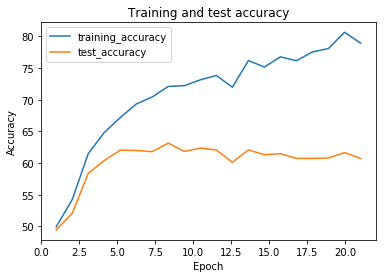

In [28]:
import matplotlib.pyplot as plt
import numpy as np
epoch = np.linspace(1,21,20)
fig = plt.figure()
plt.plot(epoch, training_acc, label = 'training_accuracy')
plt.plot(epoch, test_acc, label = 'test_accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
fig.savefig('LeNet5_result.jpg')